In [1]:
import pickle
import sys
import os
from pathlib import Path

# Добавляем путь на уровень выше
sys.path.append(str(Path(os.getcwd()).resolve().parent))

import numpy as np
import pandas as pd
import json
from pathlib import Path
from utils.feature_engineering import add_features
from utils.features import *

# Загрузка данных из np.memmap
def load_memmap(data_path, shape, dtype='float32', mode='r'):
    """Загружает данные из файла np.memmap."""
    return np.memmap(data_path, dtype=dtype, mode=mode, shape=shape)[:2016]

# Сохранение данных в np.memmap
def save_memmap(data, data_path, dtype='float32'):
    """Сохраняет данные в файл np.memmap."""
    # Преобразуем data_path в объект Path
    data_path = Path(data_path)
    
    # Проверяем, существует ли папка
    if not data_path.parent.exists():
        # Создаем папку, если она не существует
        data_path.parent.mkdir(parents=True, exist_ok=True)
        print(f"Папка {data_path.parent} создана.")

    # Сохраняем данные в np.memmap
    memmap = np.memmap(data_path, dtype=dtype, mode='w+', shape=data.shape)
    memmap[:] = data[:]
    memmap.flush()
    print(f"Данные сохранены в {data_path}.")

def load_pkl(pickle_file: str) -> object:
    """
    Load data from a pickle file.

    Args:
        pickle_file (str): Path to the pickle file.

    Returns:
        object: Loaded object from the pickle file.
    """

    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print(f'Unable to load data from {pickle_file}: {e}')
        raise
    return pickle_data

In [2]:
# Загрузка данных
data_dir = Path('../data/all_data/PEMS-BAY')
data_path = data_dir / 'data.dat'
metadata_path = data_dir / 'desc.json'
adj_path = data_dir / 'adj_mx.pkl'

# Загрузка метаданных
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Загрузка данных
data_shape = (metadata['num_time_steps'], metadata['num_nodes'], metadata['num_features'])
data = load_memmap(data_path, shape=data_shape)

try:
    _, _, adj_mx_pb = load_pkl(adj_path)
except ValueError:
    adj_mx_pb = load_pkl(adj_path)


# # Загрузка данных
# data_dir = Path('../data/all_data/METR-LA')
# data_path = data_dir / 'data.dat'
# metadata_path = data_dir / 'desc.json'
# adj_path = data_dir / 'adj_mx.pkl'

# # Загрузка метаданных
# with open(metadata_path, 'r') as f:
#     metadata = json.load(f)

# # Загрузка данных
# data_shape = (metadata['num_time_steps'], metadata['num_nodes'], metadata['num_features'])
# data2 = load_memmap(data_path, shape=data_shape)

# try:
#     _, _, adj_mx_ml = load_pkl(adj_path)
# except ValueError:
#     adj_mx_ml = load_pkl(adj_path)


### Статистики:

In [ ]:
import matplotlib.pyplot as plt
# Создаем временной индекс, начиная с 01.01.2017
time_index = pd.date_range(start='2017-01-01', periods=data.shape[0], freq='5T')  # '5T' — интервал 5 минут
# Создаем DataFrame
data_pb = pd.DataFrame(data[:, :, 0], index=time_index)
data_pb.mean(axis=1).plot(figsize=(12, 6))
plt.xlabel('Время')
plt.ylabel('Скорость, миль/ч')
plt.title('Средняя скорость датасета PEMS-BAY')
plt.show()

data_ml = pd.DataFrame(data2[:, :, 0], index=pd.date_range(start='2012-03-01', periods=data.shape[0], freq='5T'))
data_ml.mean(axis=1).plot(figsize=(12, 6))
plt.xlabel('Время')
plt.ylabel('Скорость, миль/ч')
plt.title('Средняя скорость датасета METR-LA')
plt.show()


In [ ]:
data_pb.std(axis=1).plot(figsize=(12, 6))
plt.title('Среднее отклонение датасета PEMS-BAY')
plt.show()

data_pb.mean(axis=1).plot(label="Средняя скорость для всех узлов", figsize=(12, 6))
data_pb.median(axis=1).plot(label="Медианная скорость для всех узлов", figsize=(12, 6))
plt.title('Средние и медианные значения датасета PEMS-BAY')
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose
import matplotlib.pyplot as plt

# # Предположим, что df — это DataFrame с одним столбцом данных
# # и индексом в формате даты/времени
# result = seasonal_decompose(data_pb.mean(axis=1).values, model='additive', period=288)  # seasonal — период сезонности
# # Визуализация компонент
# plt.figure(figsize=(16, 8))
# result.plot()
# plt.show()

data_pb.mean(axis=1).diff(1).plot()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Построение гистограммы
plt.figure(figsize=(10, 6))
sns.histplot(data_pb.values.reshape(-1), bins=50, kde=True)
plt.title("Распределение скоростей датасета PEMS-BAY")
plt.xlabel("Скорость, миль/ч")
plt.ylabel("Частота")
plt.show()

# Построение гистограммы
plt.figure(figsize=(10, 6))
sns.histplot(data_ml.values.reshape(-1), bins=50, kde=True)
plt.title("Распределение скоростей датасета METR-LA")
plt.xlabel("Скорость, миль/ч")
plt.ylabel("Частота")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Создаем фигуру и оси
plt.figure(figsize=(16, 8))

# Построение графиков
for i in range(1, 3):
    # Выбираем данные для i-го дня
    day_data = data_pb.iloc[i*288:(i+1)*288, :].mean(axis=1).reset_index(drop=True)
    # Строим график
    day_data.plot()

# Добавляем подписи
plt.title('Наложенные графики по разным дням')
plt.xlabel('Временные интервалы (5 минут)')
plt.ylabel('Скорость, миль/ч')
plt.legend([f'День {i+2}' for i in range(7)])  # Легенда для каждого дня
plt.grid(True)
plt.show()

In [ ]:
# Выберем один узел (датчик) для анализа
node_data = data_pb.iloc[:, 0].values / data_pb.iloc[:, 0].values.max()  # Первый узел (можно выбрать любой)

# 1. Применение FFT
fft_values = np.fft.fft(node_data)  # FFT для временного ряда
frequencies = np.fft.fftfreq(len(node_data))  # Соответствующие частоты

# # 2. Визуализация амплитудного спектра
# plt.figure(figsize=(12, 6))
# plt.plot(frequencies, np.abs(fft_values))
# plt.title("Амплитудный спектр FFT")
# plt.xlabel("Частота")
# plt.ylabel("Амплитуда")
# plt.grid()
# plt.show()

# 3. Выделение основных частотных компонентов
# Отфильтруем низкие частоты (периодические компоненты)
threshold = 0.001 * np.max(np.abs(fft_values))  # Порог для фильтрации
fft_filtered = fft_values.copy()
fft_filtered[np.abs(fft_values) < threshold] = 0  # Убираем шум

# 4. Обратное преобразование Фурье для выделения периодических компонентов
filtered_signal = np.fft.ifft(fft_filtered).real  # Обратное FFT

# 5. Визуализация исходного и выделенного сигналов
plt.figure(figsize=(8, 4))
plt.plot(node_data, label="Исходный сигнал", alpha=0.7)
plt.plot(filtered_signal, label="Выделенные периодические компоненты", color="red")
plt.title("Исходный сигнал и выделенные периодические компоненты")
plt.xlabel("Временные интервалы")
plt.ylabel("Значения")
plt.legend()
plt.grid()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
import pywt

# Выберем один узел (датчик) для анализа
node_data = data_pb.iloc[:, 0].values / data_pb.iloc[:, 0].values.max()  # Нормализация данных

# 1. Применение вейвлет-преобразования
# Выбираем вейвлет Добеши 4-го порядка (можно выбрать другой вейвлет)
wavelet = 'db4'
coeffs = pywt.wavedec(node_data, wavelet, level=5)  # Разложение на 5 уровней

# 2. Визуализация коэффициентов вейвлета
plt.figure(figsize=(12, 8))
for i, coeff in enumerate(coeffs):
    plt.subplot(len(coeffs), 1, i+1)
    plt.plot(coeff)
    plt.title(f"Уровень {i} коэффициентов вейвлета")
plt.tight_layout()
plt.show()

# 3. Фильтрация коэффициентов (убираем шум)
# Оставляем только коэффициенты, соответствующие основным компонентам
coeffs_filtered = [coeffs[0]]  # Оставляем аппроксимацию (низкочастотные компоненты)
for i in range(1, len(coeffs)):
    coeffs_filtered.append(np.zeros_like(coeffs[i]))  # Убираем детали (высокочастотные компоненты)

# 4. Восстановление сигнала после фильтрации
filtered_signal = pywt.waverec(coeffs_filtered, wavelet)

# 5. Визуализация исходного и выделенного сигналов
plt.figure(figsize=(12, 6))
plt.plot(node_data, label="Исходный сигнал", alpha=0.7)
plt.plot(filtered_signal, label="Выделенные периодические компоненты", color="red")
plt.title("Исходный сигнал и выделенные периодические компоненты (вейвлет-преобразование)")
plt.xlabel("Временные интервалы")
plt.ylabel("Значения")
plt.legend()
plt.grid()
plt.show()

In [ ]:
data_pb.iloc[0*288:288*1, :10].boxplot(figsize=(16, 8))
plt.xlabel('Порядковый номер узла')
plt.ylabel('Скорость, миль/ч')
plt.title('Боксплот для выходного дня датасета PEMS-BAY')
plt.show()

data_pb.iloc[1*288:288*2, :10].boxplot(figsize=(16, 8))
plt.xlabel('Порядковый номер узла')
plt.ylabel('Скорость, миль/ч')
plt.title('Боксплот для буднего дня датасета PEMS-BAY')
plt.show()

### Конец статистик

In [3]:
# Разделение данных на train, val и test
train_ratio, val_ratio, test_ratio = metadata['regular_settings']['TRAIN_VAL_TEST_RATIO']
train_len = int(2016 * train_ratio)
val_len = int(2016 * val_ratio)
test_len = 2016 - train_len - val_len

train_data = data[:train_len]
val_data = data[train_len:train_len + val_len]
test_data = data[train_len + val_len:]

In [4]:
# Определение функций
feature_functions = {
    # 'minute': minute_index_feature,
    # 'weekday': weekday_index_feature,
    # 'fft': fft_denoise_feature,
    # 'mean': mean_feature,
    # 'median': median_feature,
    # 'std': std_feature,
    # 'min': min_feature,
    # 'max': max_feature,
    # 'kurtosis': kurtosis_feature,
    # 'skew': skew_feature,
    # 'quantile': quantile_feature,
    # 'rolling_mean': rolling_mean_feature,
    # 'rolling_std': rolling_std_feature,
    # 'rolling_min': rolling_min_feature,
    # 'rolling_max': rolling_max_feature,
}

graph_feature_functions = {
    # 'degree': degree_feature,
    # 'node_index': node_indices_feature,
    'degree_centrality': degree_centrality_feature,
    'closeness_centrality': closeness_centrality_feature,
    'betweenness_centrality': betweenness_centrality_feature,
    'clustering_coefficient': clustering_coefficient_feature
}

# Добавление фичей для train
train_data_extended = add_features(
    train_data,
    feature_list=list(feature_functions.keys()),
    feature_functions=feature_functions,
    graph_feature_functions=graph_feature_functions,
    index=None,
    adj_matrix=adj_mx_pb
)

# Добавление фичей для val
val_data_extended = add_features(
    val_data,
    feature_list=list(feature_functions.keys()),
    feature_functions=feature_functions,
    graph_feature_functions=graph_feature_functions,
    index=None,
    adj_matrix=adj_mx_pb
)

# Добавление фичей для test
test_data_extended = add_features(
    test_data,
    feature_list=list(feature_functions.keys()),
    feature_functions=feature_functions,
    graph_feature_functions=graph_feature_functions,
    index=None,
    adj_matrix=adj_mx_pb
)


In [6]:
processed_data = np.concatenate([train_data_extended, val_data_extended, test_data_extended], axis=0)

array([[<Axes: title={'center': '0'}>]], dtype=object)

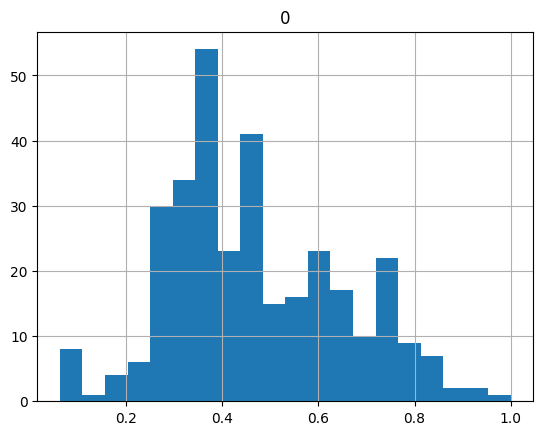

In [36]:
pd.DataFrame(processed_data[0, :, -1] / processed_data[0, :, -1].max(axis=0)).hist(bins=20)

In [6]:
# Берем последние 4 колонки для всех временных шагов и узлов
test = processed_data[:, :, -4:]
max_values = test.max(axis=(0, 1))  # Максимум для каждого из 4 столбцов
test_normalized = test / max_values

# Обновляем последние 4 колонки в исходном массиве
processed_data[:, :, -4:] = test_normalized


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Вычисляем средние значения по оси 1 (узлы)
mean_channel_0 = pd.DataFrame(processed_data[:288, :, 0]).mean(axis=0)
mean_channel_last = pd.DataFrame(processed_data[:288, :, -1]).mean(axis=0)

# Нормализуем данные
mean_channel_0_normalized = (mean_channel_0 - mean_channel_0.min()) / (mean_channel_0.max() - mean_channel_0.min())
mean_channel_last_normalized = (mean_channel_last - mean_channel_last.min()) / (mean_channel_last.max() - mean_channel_last.min())

# Отображаем на одном графике
plt.figure(figsize=(10, 6))
plt.plot(mean_channel_0_normalized, label='Channel 0 (Normalized)')
plt.plot(mean_channel_last_normalized, label='Last Channel (Normalized)')
plt.title('Normalized Mean Values')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

In [8]:
# Сохранение обновленных данных
processed_data_path = data_dir / 'new2' / 'data.dat'
save_memmap(processed_data, processed_data_path)

# Обновление метаданных
updated_metadata = metadata.copy()
updated_metadata['shape'] = list(processed_data.shape)
updated_metadata['num_time_steps'] = processed_data.shape[0]
updated_metadata['num_features'] = processed_data.shape[2]

# Сохранение обновленных метаданных
updated_metadata_path = data_dir / 'new2' / 'desc.json'
with open(updated_metadata_path, 'w') as f:
    json.dump(updated_metadata, f, indent=4)

print("Данные успешно обработаны и сохранены.")

Папка ..\data\all_data\PEMS-BAY\new2 создана.
Данные сохранены в ..\data\all_data\PEMS-BAY\new2\data.dat.
Данные успешно обработаны и сохранены.
